In [1]:
import pandas as pd
import numpy as np
from matplotlib.colors import rgb2hex
import datetime as dt
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from haversine import haversine, Unit
import matplotlib.colors as mcolors


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
creepmeters = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes_updated.csv')
creepmeters.drop_duplicates('Creepmeter_abbrv',inplace=True)
creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='XMBC'].index,inplace=True)
creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='TABC'].index,inplace=True)
creepmeters.reset_index(inplace=True,drop=True)
print(creepmeters)

    Unnamed: 0 Network Creepmeter_abbrv File_code  \
0            0     EAF             BAL1   BAL1_1T   
1            1    PARK             C461  C461_10T   
2            2    PARK             C462   C462_1T   
3            3     UTA             CAN1  CAN1_30T   
4            4     NAF             CER1  CER1_30S   
..         ...     ...              ...       ...   
73         128     EAF             YZW1   YZW1_1T   
74         129   SOCAL             COML  COML_30T   
75         130   SOCAL             COLE  COLE_30T   
76         131   SOCAL             COLW   COLW_5T   
77         133   SOCAL             EASH   EASH_5T   

                     Start Time                     End Time  \
0   2023-03-12T10:47:55.000000Z  2023-09-05T13:14:55.000000Z   
1   2004-09-29T02:20:00.000000Z  2022-06-20T12:40:00.000000Z   
2   2021-08-19T19:10:11.000000Z  2024-03-22T01:05:11.000000Z   
3   2012-06-12T15:33:00.000000Z  2017-06-15T08:33:00.000000Z   
4   2019-10-09T06:46:00.000000Z  2024-05-23

In [3]:
########## East Anatolia ############
EAF = creepmeters.drop(creepmeters[creepmeters["Network"]!="EAF"].index)
EAF.reset_index(inplace=True,drop=True)
EAF.sort_values(by='Latitude',inplace=True,ascending=False)
EAF.reset_index(inplace=True,drop=True)

########## North Anatolia ############
NAF = creepmeters.drop(creepmeters[creepmeters["Network"]!="NAF"].index)
NAF.sort_values(by='Longitude',inplace=True,ascending=True)
NAF.reset_index(inplace=True,drop=True)


########## Parkfield ############
PARK = creepmeters.drop(creepmeters[creepmeters["Network"]!="PARK"].index)
PARK.reset_index(inplace=True,drop=True)
PARK.sort_values(by='Latitude',inplace=True,ascending=False)
PARK.reset_index(inplace=True,drop=True)
PARK

########## Hayward ############
HAY = creepmeters.drop(creepmeters[creepmeters["Network"]!="HAY"].index)
HAY.sort_values(by='Latitude',inplace=True,ascending=False)
HAY.reset_index(inplace=True,drop=True)
HAY

########## Hollister ############
HOL = creepmeters.drop(creepmeters[creepmeters["Network"]!="HOL"].index)
HOL.reset_index(inplace=True,drop=True)
CAL = creepmeters.drop(creepmeters[creepmeters["Network"]!="CAL"].index)
CAL.reset_index(inplace=True,drop=True)
print(CAL)
HOL = pd.concat([HOL,CAL],ignore_index=True)
HOL.sort_values(by='Latitude',inplace=True,ascending=False)
HOL.reset_index(inplace=True,drop=True)

########## Chaman ############
CHAF = creepmeters.drop(creepmeters[creepmeters["Network"]!="CHAF"].index)
CHAF.reset_index(inplace=True,drop=True)

########## Dead Sea ############
DSF = creepmeters.drop(creepmeters[creepmeters["Network"]!="DSF"].index)
DSF.reset_index(inplace=True,drop=True)

########## Utah ############
UTA = creepmeters.drop(creepmeters[creepmeters["Network"]!="UTA"].index)
UTA.reset_index(inplace=True,drop=True)

########## SoCal ############
SOCAL= creepmeters.drop(creepmeters[creepmeters["Network"]!="SOCAL"].index)
SOCAL.sort_values(by='Latitude',inplace=True,ascending=False)
SOCAL.reset_index(inplace=True,drop=True)

########## Ridgecrest ############
RID = creepmeters.drop(creepmeters[creepmeters["Network"]!="RID"].index)
RID.sort_values(by='Latitude',inplace=True,ascending=False)
RID.reset_index(inplace=True,drop=True)

   Unnamed: 0 Network Creepmeter_abbrv File_code                   Start Time  \
0         122     CAL             XSH1   XSH1_1T  2020-10-15T17:01:59.000000Z   

                      End Time  Sampling rate, Hz Sampling rate, mins  \
0  2024-10-09T18:37:59.000000Z           0.016667                  1T   

   Latitude  Longitude Length Depth  Obliquity Creepmeter_full_name  \
0    36.943   -121.445   14 m   NaN       41.5          Shore Rd #1   

             Fault  
0  Calaveras Fault  


In [4]:
cmap=cmc.managua

In [5]:
df_all = pd.read_csv("../../Data/DATA_tidied/Picks/All_picks_29_May_2025.csv",index_col=0)

df_all['Start Time'] = pd.to_datetime(df_all['Start Time'])
df_all.drop(df_all[df_all['Start Time']>dt.datetime(2024,1,1,0,0,0)].index,inplace=True)
df_all.drop(df_all[df_all['Displacement, mm']<0.02].index,inplace=True)

Propagation

In [6]:
def directional_distance(point1, point2):
    """
    Returns:
    - total distance (km) using Haversine
    - lat_diff (positive if point2 is north of point1)
    - lon_diff (positive if point2 is east of point1)
    """
    lat1, lon1 = point1
    lat2, lon2 = point2

    # Total great-circle distance
    distance = haversine(point1, point2, unit=Unit.KILOMETERS)

    # Directional components
    lat_diff = lat2 - lat1  # > 0 if point2 is north
    lon_diff = lon2 - lon1  # > 0 if point2 is east
    north_south_distance = distance * (1 if lat_diff > 0 else -1)

    return north_south_distance

In [87]:
def propagation_plot(instrument_array, events, network, selected_station,velocities,start,end,mps_values):
    NSAF = instrument_array[instrument_array['Network'] == network].copy()
    NSAF = NSAF[NSAF['Creepmeter_abbrv'] != 'CWC3'].reset_index(drop=True)

    index_location = np.where(NSAF['Creepmeter_abbrv'] == selected_station)[0][0]
    station_full_name = NSAF['Creepmeter_full_name'].iloc[index_location]
    station_lat = NSAF['Latitude'].iloc[index_location]
    station_long = NSAF['Longitude'].iloc[index_location]

    HOL_events = events[events['Network'] == network].copy()
    HOL_events = HOL_events[(pd.to_datetime(HOL_events['Start Time']) >= dt.datetime(start, 1, 1)) &
                            (pd.to_datetime(HOL_events['Start Time']) <= dt.datetime(end, 1, 1))].reset_index(drop=True)

    station_events = HOL_events[HOL_events['Latitude'] == station_lat]
    HOL_events = HOL_events[HOL_events['Latitude'] != station_lat]

    distances = []
    locs = np.unique(HOL_events['Latitude'])

    fig, ax1 = plt.subplots(figsize=(10, 20))

    ax1.axhline(0, color='gray', linestyle='--')
    ax1.axvline(0, color='gray', linestyle='--')
    ax1.set_xlabel(f'Distance from {station_full_name}, km')
    ax1.set_ylabel(f'Time to closest {station_full_name} event, hrs')

    markers = ['o', 's', '^', 'v', '<', '>', 'D', 'p', '*', 'h', 'X', '+']

    if network == 'PARK':
        station_names = ['Highway 46, X', 'Highway 46, C', 'Gold Hill', 'Carr Ranch',
                            'Work Ranch', 'Hearst, SW trace', 'Taylor Ranch', 'Parkfield',
                            'Roberson, SW trace', 'Varian', 'Middle Ridge', 'Slacks Canyon']
    elif network == 'HOL':
        station_names = ['Melendy Ranch', 'Fox Creek', 'Harris Ranch', 'San Juan Bautista', 'Nyland Ranch']
    elif network == 'HAY':
        station_names = ['Fremont Winery','Hayward Palisades St #2','Oakland Zoo','Temescal',
                        'Pt Pinole']

    for i, lat in enumerate(locs):
        if i >= len(markers):  # prevent index error if more latitudes than markers
            break

        event_select = HOL_events[HOL_events['Latitude'] == lat]
        long = np.unique(event_select['Longitude'])[0]
        distance_km = directional_distance((lat, long), (station_lat, station_long))
        distances.append(distance_km)

        A_times = pd.to_datetime(station_events['Start Time']).sort_values().reset_index(drop=True)
        B_times = pd.to_datetime(event_select['Start Time']).sort_values().reset_index(drop=True)

        closest_deltas = []
        for time in A_times:
            deltas = B_times - time
            closest_delta = deltas.iloc[deltas.abs().argmin()]
            hours = closest_delta.total_seconds() / (60 * 60)
            closest_deltas.append(hours)

        ax1.scatter([distance_km] * len(closest_deltas), closest_deltas, color='grey',
                    alpha=0.5, marker=markers[i])
    distances.append(0)
    distances = np.array(distances)
    min_neg = np.floor(np.min(distances[distances < 0]))
    try:
        max_pos = np.ceil(np.max(distances[distances > 0]))
    except ValueError:
        max_pos=1
    ax1.set_xlim([min_neg, max_pos])
    ax1.set_ylim([-720, 720])

    colours = cmc.batlow_r(np.linspace(0, 1, len(velocities)))
    linestyles = ['-', '--', '-.', ':', (0, (1, 1)), (0, (5, 1)),
                  (0, (3, 5, 1, 5)), (0, (5, 10)), (0, (1, 10))]

    x = np.linspace(min_neg, max_pos, 500)
    for j, v in enumerate(velocities):
        y = (x / v)
        ax1.plot(x, y, label=f'{mps_values[j]} m/s', color=mcolors.to_hex(colours[j]), linestyle=linestyles[j])
        ax1.plot(x, -y, color=mcolors.to_hex(colours[j]), linestyle=linestyles[j])

    # Legends
    # Velocity lines legend
    legend_velocity = ax1.legend(title="Propagation velocity", loc="upper left", frameon=True)

    # Station marker legend (empty scatter for legend only)
    station_handles = [
        ax1.scatter([], [], color='gray', alpha=0.5, marker=markers[i], label=station_names[i])
        for i in range(min(len(station_names), len(markers)))
    ]
    legend_stations = ax1.legend(
        handles=station_handles,
        ncols=5,
        title='Stations',
        loc='lower left',
        frameon=True,
        labelspacing=1.2,
        borderpad=1.0,
        scatterpoints=1
    )
    ax1.add_artist(legend_velocity)
    ax1.add_artist(legend_stations)

    plt.tight_layout()
    plt.show()


In [88]:
mps_values = [1E-5,0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
kmph_values = [v * 3.6 for v in mps_values]

#kmph_values = [0.001,0.01,0.025,0.05, 0.075,0.1,0.25,0.5,1,2,4]

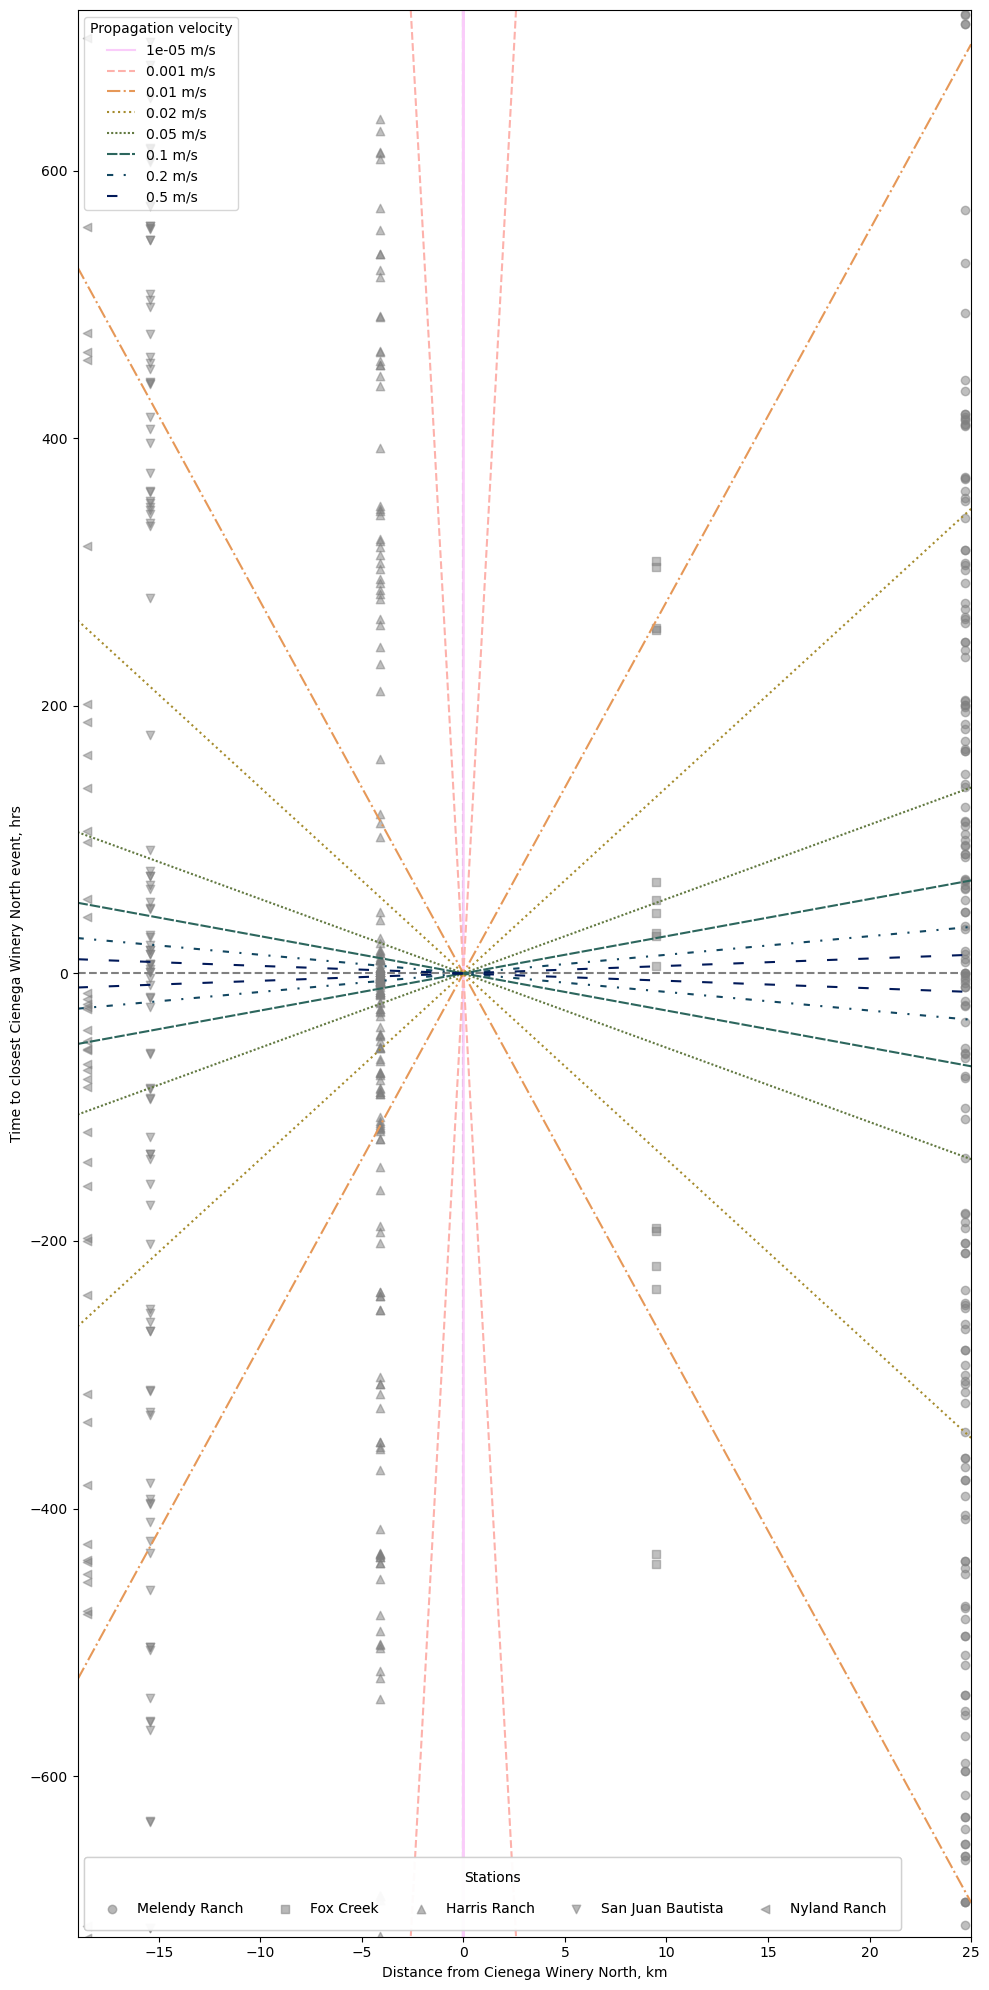

In [89]:
propagation_plot(HOL, df_all, 'HOL','CWN1',kmph_values,1992,2024,mps_values)

In [ ]:
def propagation_plot(instrument_array, events, network, selected_station,velocities,start,end,mps_values):
    NSAF = instrument_array[instrument_array['Network'] == network].copy()
    NSAF = NSAF[NSAF['Creepmeter_abbrv'] != 'CWC3'].reset_index(drop=True)

    index_location = np.where(NSAF['Creepmeter_abbrv'] == selected_station)[0][0]
    station_full_name = NSAF['Creepmeter_full_name'].iloc[index_location]
    station_lat = NSAF['Latitude'].iloc[index_location]
    station_long = NSAF['Longitude'].iloc[index_location]

    HOL_events = events[events['Network'] == network].copy()
    HOL_events = HOL_events[(pd.to_datetime(HOL_events['Start Time']) >= dt.datetime(start, 1, 1)) &
                            (pd.to_datetime(HOL_events['Start Time']) <= dt.datetime(end, 1, 1))].reset_index(drop=True)

    station_events = HOL_events[HOL_events['Latitude'] == station_lat]
    HOL_events = HOL_events[HOL_events['Latitude'] != station_lat]

    distances = []
    locs = np.unique(HOL_events['Latitude'])

    fig, ax1 = plt.subplots(figsize=(10, 20))

    

    for i, lat in enumerate(locs):
        

        event_select = HOL_events[HOL_events['Latitude'] == lat]
        long = np.unique(event_select['Longitude'])[0]
        distance_km = directional_distance((lat, long), (station_lat, station_long))
        distances.append(distance_km)

        A_times = pd.to_datetime(station_events['Start Time']).sort_values().reset_index(drop=True)
        B_times = pd.to_datetime(event_select['Start Time']).sort_values().reset_index(drop=True)

        closest_deltas = []
        for time in A_times:
            deltas = B_times - time
            closest_delta = deltas.iloc[deltas.abs().argmin()]
            hours = closest_delta.total_seconds() / (60 * 60)
            closest_deltas.append(hours)

        velocities = [distance_km] * len(closest_deltas)/closest_deltas

        
    distances.append(0)
    distances = np.array(distances)
    min_neg = np.floor(np.min(distances[distances < 0]))
    try:
        max_pos = np.ceil(np.max(distances[distances > 0]))
    except ValueError:
        max_pos=1
    ax1.set_xlim([min_neg, max_pos])
    ax1.set_ylim([-720, 720])

    colours = cmc.batlow_r(np.linspace(0, 1, len(velocities)))
    linestyles = ['-', '--', '-.', ':', (0, (1, 1)), (0, (5, 1)),
                  (0, (3, 5, 1, 5)), (0, (5, 10)), (0, (1, 10))]

    x = np.linspace(min_neg, max_pos, 500)
    for j, v in enumerate(velocities):
        y = (x / v)
        ax1.plot(x, y, label=f'{mps_values[j]} m/s', color=mcolors.to_hex(colours[j]), linestyle=linestyles[j])
        ax1.plot(x, -y, color=mcolors.to_hex(colours[j]), linestyle=linestyles[j])

    # Legends
    # Velocity lines legend
    legend_velocity = ax1.legend(title="Propagation velocity", loc="upper left", frameon=True)

    # Station marker legend (empty scatter for legend only)
    station_handles = [
        ax1.scatter([], [], color='gray', alpha=0.5, marker=markers[i], label=station_names[i])
        for i in range(min(len(station_names), len(markers)))
    ]
    legend_stations = ax1.legend(
        handles=station_handles,
        ncols=5,
        title='Stations',
        loc='lower left',
        frameon=True,
        labelspacing=1.2,
        borderpad=1.0,
        scatterpoints=1
    )
    ax1.add_artist(legend_velocity)
    ax1.add_artist(legend_stations)

    plt.tight_layout()
    plt.show()


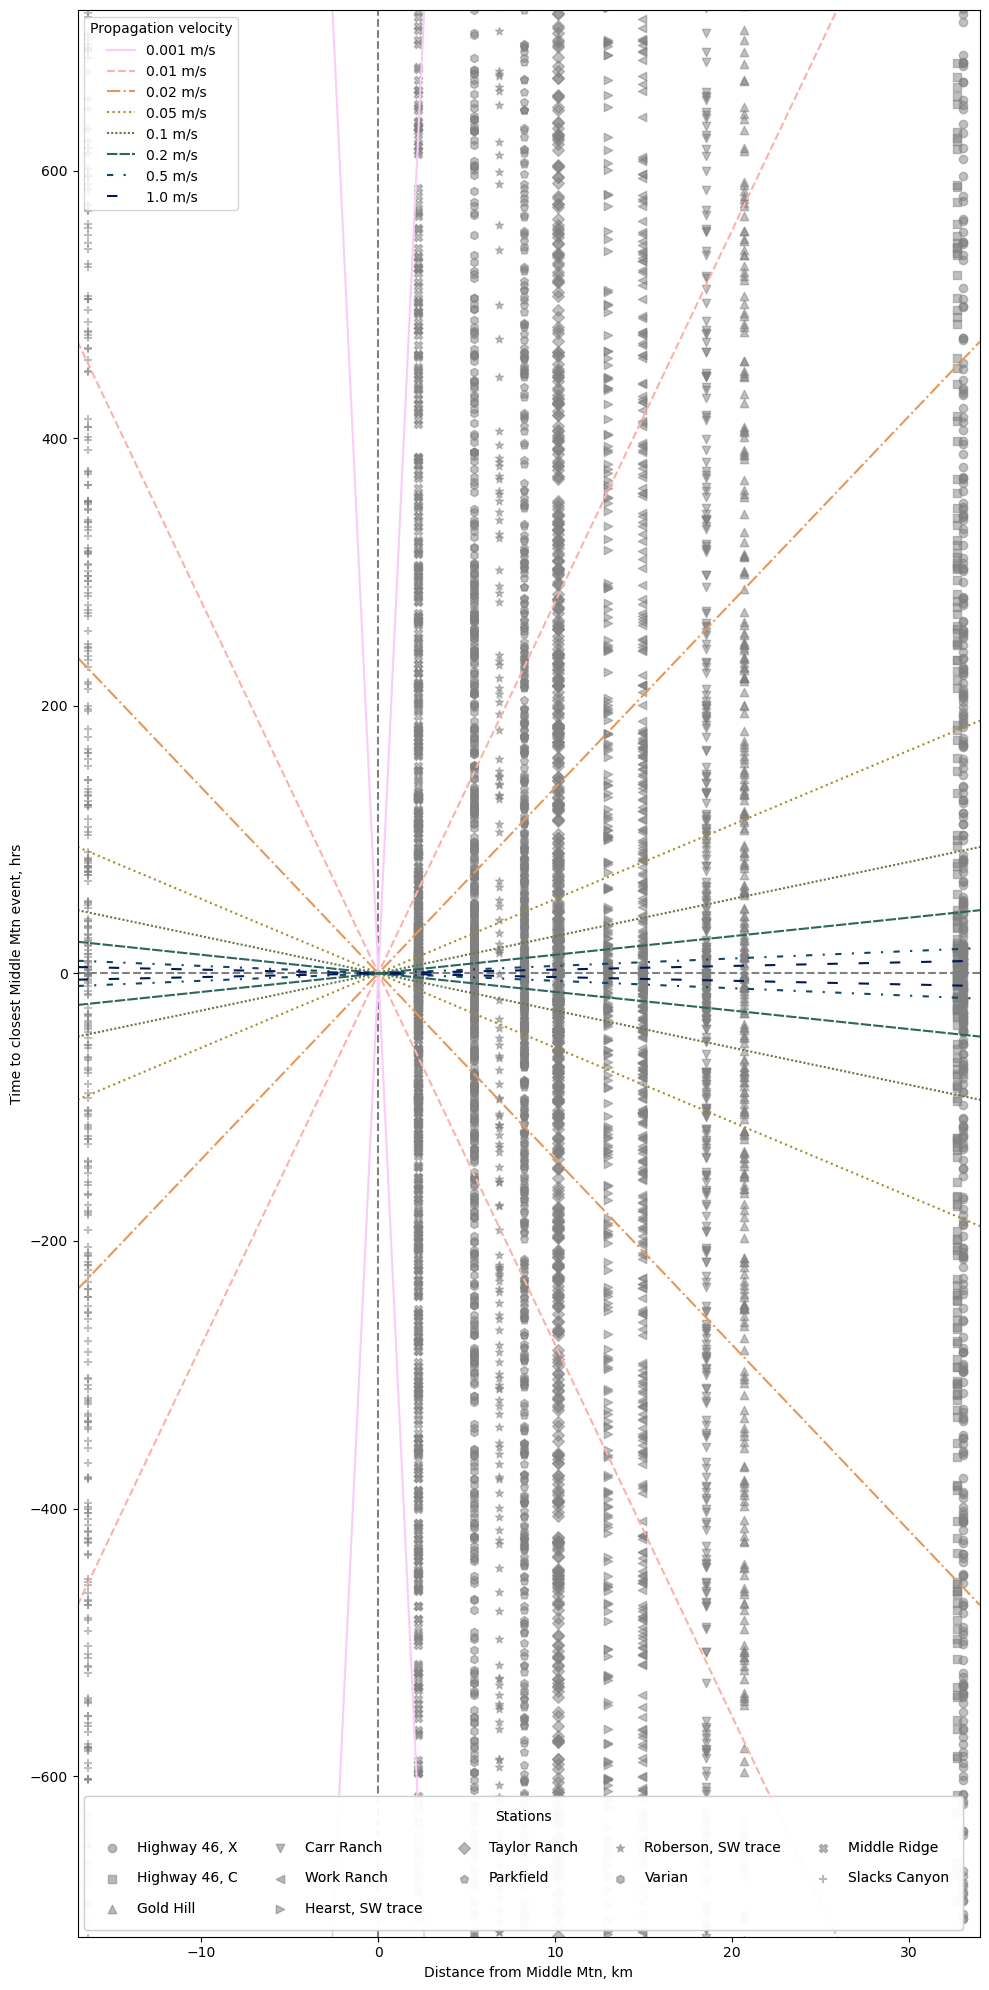

In [64]:
propagation_plot(PARK, df_all, 'PARK','XMM1',kmph_values,1980,2024,mps_values)

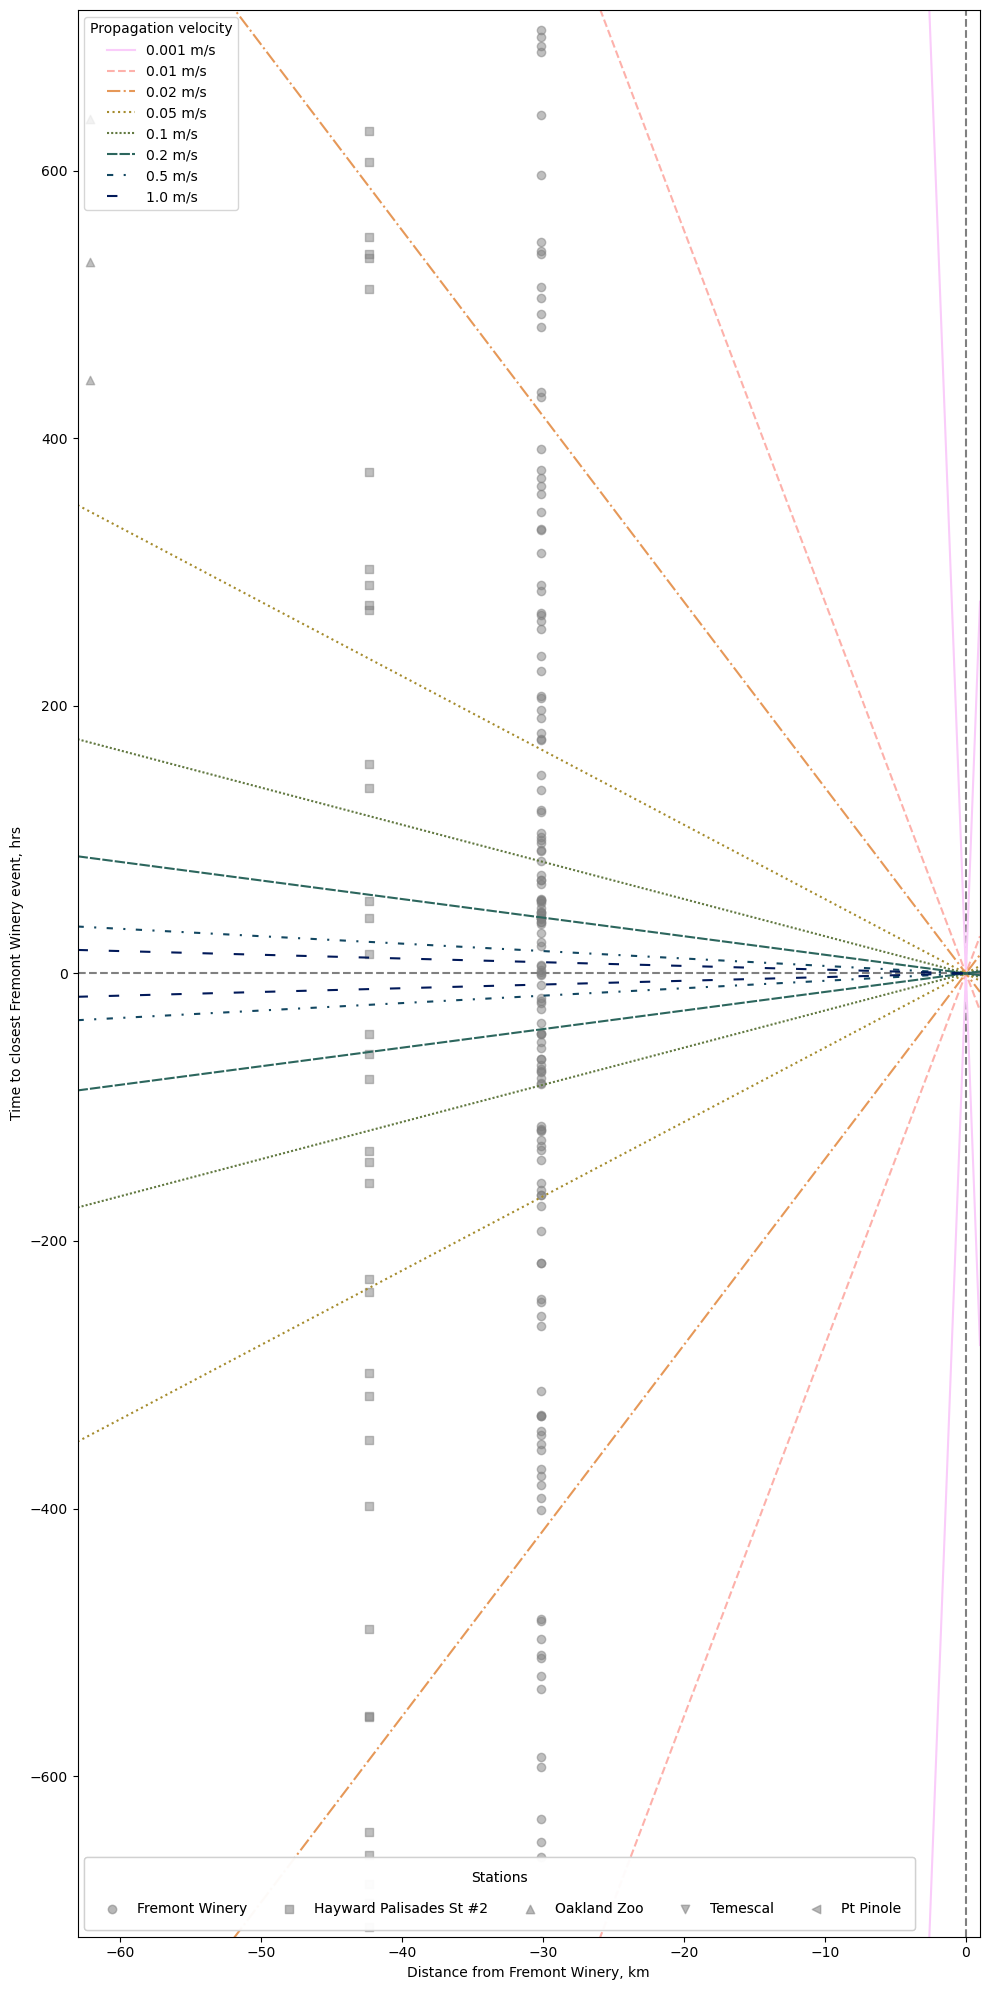

In [65]:
propagation_plot(HAY, df_all, 'HAY','CFW1',kmph_values,1993,2024,mps_values)

In [27]:
def propagation_percentage(instrument_array, events, network, selected_station,velocities,start,end):
    NSAF = instrument_array[instrument_array['Network'] == network].copy()
    NSAF = NSAF[NSAF['Creepmeter_abbrv'] != 'CWC3'].reset_index(drop=True)

    index_location = np.where(NSAF['Creepmeter_abbrv'] == selected_station)[0][0]
    station_full_name = NSAF['Creepmeter_full_name'].iloc[index_location]
    station_lat = NSAF['Latitude'].iloc[index_location]
    station_long = NSAF['Longitude'].iloc[index_location]

    HOL_events = events[events['Network'] == network].copy()
    HOL_events = HOL_events[(pd.to_datetime(HOL_events['Start Time']) >= dt.datetime(start, 1, 1)) &
                            (pd.to_datetime(HOL_events['Start Time']) <= dt.datetime(end, 1, 1))].reset_index(drop=True)

    station_events = HOL_events[HOL_events['Latitude'] == station_lat]
    HOL_events = HOL_events[HOL_events['Latitude'] != station_lat]

    distances = []
    locs = np.unique(HOL_events['Latitude'])



    markers = ['o', 's', '^', 'v', '<', '>', 'D', 'p', '*', 'h', 'X', '+']

    if network == 'PARK':
        station_names = ['Highway 46, X', 'Highway 46, C', 'Gold Hill', 'Carr Ranch',
                            'Work Ranch', 'Hearst, SW trace', 'Taylor Ranch', 'Parkfield',
                            'Roberson, SW trace', 'Varian', 'Middle Ridge', 'Slacks Canyon']
    elif network == 'HOL':
        station_names = ['Melendy Ranch', 'Fox Creek', 'Harris Ranch', 'San Juan Bautista', 'Nyland Ranch']
    elif network == 'HAY':
        station_names = ['Fremont Winery','Hayward Palisades St #2','Oakland Zoo','Temescal',
                        'Pt Pinole']

    for i, lat in enumerate(locs):
        if i >= len(markers):  # prevent index error if more latitudes than markers
            break

        event_select = HOL_events[HOL_events['Latitude'] == lat]
        print(np.unique(event_select['Creepmeter abbreviation']))
        long = np.unique(event_select['Longitude'])[0]
        distance_km = directional_distance((lat, long), (station_lat, station_long))
        distances.append(distance_km)

        A_times = pd.to_datetime(station_events['Start Time']).sort_values().reset_index(drop=True)
        B_times = pd.to_datetime(event_select['Start Time']).sort_values().reset_index(drop=True)

        closest_deltas = []
        for time in A_times:
            deltas = B_times - time
            closest_delta = deltas.iloc[deltas.abs().argmin()]
            days = closest_delta.total_seconds() / (60 * 60)
            closest_deltas.append(days)
        print(closest_deltas)
        print(distance_km)

        prop_velocities = [abs(distance_km / delta) for delta in closest_deltas]



    return prop_velocities

In [66]:
propagation_percentage(HOL, df_all, 'HOL','CWN1',kmph_values,1992,2024)

['XMR1']
[2349.166388888889, 2341.9997222222223, 2333.8330555555553, 1991.4997222222223, 1991.3333333333333, 1983.0, 1981.1666666666667, 1931.8330555555556, 1931.6666666666667, 1923.3333333333333, 1922.8330555555556, -390.4997222222222, -407.6666666666667, -444.1663888888889, 799.1669444444444, 799.0, 796.3333333333334, 1165.9997222222223, 1165.6663888888888, 1161.3333333333333, -809.3333333333334, -809.6666666666666, -815.6666666666666, -236.3336111111111, -292.5, -342.5002777777778, 45.833333333333336, 45.66638888888889, -362.1666666666667, -362.3336111111111, -378.3333333333333, -378.6666666666667, -281.6669444444444, -281.8336111111111, -300.0, -307.1669444444444, 418.1666666666667, 418.1666666666667, 410.6666666666667, 409.0002777777778, 35.333333333333336, 33.5, 14.666666666666666, 8.499722222222223, 414.3330555555556, 413.6666666666667, 409.6663888888889, 1491.3333333333333, 1395.6669444444444, 1393.0002777777777, 1230.0, 1229.8336111111112, 316.5, 316.5, 241.5, 203.666666666666

[0.00017319311783371778,
 0.0001732047322152922,
 0.00017321796910732242,
 0.00017377466381066257,
 0.00017377493525851806,
 0.00017378853139462462,
 0.00017379152283008632,
 0.00017387205878124465,
 0.0001738723305334608,
 0.0001738859419148311,
 0.00017388675911923516,
 0.00017813929358763392,
 0.00017816872917530367,
 0.00017823134637337973,
 0.0001802194199526344,
 0.00018021971288297272,
 0.00018022439209900115,
 0.00018616579249897139,
 0.00018616641661950211,
 0.0001861745300470803,
 0.00018993928520681845,
 0.00018993993488507246,
 0.00018995162985368166,
 0.00019544374531492429,
 0.00019555972079759028,
 0.00019566308001496853,
 0.00020165867829697654,
 0.00020165904506806568,
 0.00020255904040937742,
 0.0002025594104628871,
 0.0002025948821494548,
 0.00020259562128786447,
 0.00020922906634118362,
 0.00020922946050985446,
 0.0002092724331430991,
 0.0002092893914221682,
 0.00021161425752520605,
 0.00021161425752520605,
 0.00021163240335584995,
 0.00021163643551313322,
 0.000214

In [93]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy.spatial.distance import euclidean
from pyproj import Transformer
import random

# ---------------------------
# Step 1: Convert Lat/Lon to X/Y (UTM)
# ---------------------------

transformer = Transformer.from_crs("EPSG:4326", "EPSG:32610", always_xy=True)

station_coords_latlon = {
    0: (-122.3, 37.8),
    1: (-122.0, 37.9),
    2: (-121.7, 38.0),
    3: (-121.5, 38.1),
    4: (-121.2, 38.15),
    5: (-120.9, 38.2)
}

station_coords_xy = {
    i: transformer.transform(lon, lat)
    for i, (lon, lat) in station_coords_latlon.items()
}

# ---------------------------
# Step 2: Simulate Event Data
# ---------------------------

base_time = datetime(2023, 1, 1, 0, 0, 0)

event_times = {
    i: sorted([
        base_time + timedelta(minutes=int(random.uniform(0, 1440)))
        for _ in range(20)
    ])
    for i in range(6)
}

# ---------------------------
# Step 3: Velocity Grid Search for Events Originating at ANY Station
# ---------------------------

velocities = np.logspace(-5, 1, 300)  # 1e-5 to 10 m/s
tolerance = 5 * 60  # seconds

all_results = []

for ref_station in range(6):
    for t0 in event_times[ref_station]:
        best_match = {'velocity': None, 'match_count': 1, 'matched_stations': [ref_station]}
        
        for v in velocities:
            match_count = 1
            matched_stations = [ref_station]
            
            for i in range(6):
                if i == ref_station:
                    continue
                
                d = euclidean(station_coords_xy[i], station_coords_xy[ref_station])
                expected_t = t0 + timedelta(seconds=d / v)
                
                if any(abs((et - expected_t).total_seconds()) <= tolerance for et in event_times[i]):
                    match_count += 1
                    matched_stations.append(i)
            
            if match_count > best_match['match_count']:
                best_match = {
                    'velocity': v,
                    'match_count': match_count,
                    'matched_stations': matched_stations
                }
        
        all_results.append((
            ref_station,
            t0,
            best_match['match_count'],
            best_match['velocity'],
            best_match['matched_stations']
        ))

# ---------------------------
# Step 4: Output Results
# ---------------------------

results_df = pd.DataFrame(all_results, columns=[
    'origin_station', 'event_time', 'matched_stations_count', 'best_velocity_mps', 'matched_stations'
])

results_df['best_velocity_kmph'] = results_df['best_velocity_mps'] * 3.6

print(results_df.head(10))


   origin_station          event_time  matched_stations_count  \
0               0 2023-01-01 02:32:00                       2   
1               0 2023-01-01 02:58:00                       4   
2               0 2023-01-01 05:01:00                       4   
3               0 2023-01-01 07:26:00                       4   
4               0 2023-01-01 09:01:00                       3   
5               0 2023-01-01 09:18:00                       3   
6               0 2023-01-01 10:17:00                       3   
7               0 2023-01-01 10:18:00                       3   
8               0 2023-01-01 13:22:00                       3   
9               0 2023-01-01 13:47:00                       3   

   best_velocity_mps matched_stations  best_velocity_kmph  
0           0.376055           [0, 1]            1.353796  
1           6.597782     [0, 3, 4, 5]           23.752017  
2           2.618546     [0, 1, 2, 5]            9.426765  
3           2.387407     [0, 2, 3, 5]       

In [129]:
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy.spatial.distance import pdist, euclidean
from pyproj import Transformer


def find_stations_between_extremes(matched_stations, station_coords_xy):
    """
    Find stations in matched_stations that lie spatially between the two
    most distant stations based on their XY coordinates.

    Parameters:
        matched_stations (list of str): Station names involved in the event.
        station_coords_xy (dict): Mapping from station name to (x, y) coordinates.

    Returns:
        list of str: Station names that lie between the two furthest stations.
    """

    # Step 1: Get all station coordinates
    coords = {st: np.array(station_coords_xy[st]) for st in matched_stations}

    # Step 2: Find the two most distant stations
    max_dist = -1
    endpoint_pair = (None, None)

    for i in range(len(matched_stations)):
        for j in range(i + 1, len(matched_stations)):
            st1, st2 = matched_stations[i], matched_stations[j]
            dist = euclidean(coords[st1], coords[st2])
            if dist > max_dist:
                max_dist = dist
                endpoint_pair = (st1, st2)

    a, b = coords[endpoint_pair[0]], coords[endpoint_pair[1]]
    ab_vec = b - a
    ab_len_sq = np.dot(ab_vec, ab_vec)

    # Step 3: Identify stations between the two endpoints using projection
    stations_between = []

    for st in matched_stations:
        if st in endpoint_pair:
            continue
        p = coords[st]
        ap_vec = p - a

        # Project point onto the AB vector
        t = np.dot(ap_vec, ab_vec) / ab_len_sq

        # Check if the station lies *between* a and b (not beyond either)
        if 0 < t < 1:
            stations_between.append(st)

    return stations_between


# ----------------------------------------------
# Merge nearby-in-time events that occurred at the same set of stations
# ----------------------------------------------
def merge_close_events(results_df, station_coords_xy, time_threshold=timedelta(minutes=5)):
    # Sort events by station and time
    results_df = results_df.sort_values(['origin_station', 'event_time']).reset_index(drop=True)
    merged_events = []
    used_indices = set()

    for i, row_i in results_df.iterrows():
        if i in used_indices:
            continue

        group = [i]  # Start a new merge group

        for j in range(i+1, len(results_df)):
            row_j = results_df.iloc[j]
            # Events must have identical station sets and be close in time
            if set(row_i['matched_stations']) == set(row_j['matched_stations']):
                if abs(row_i['event_time'] - row_j['event_time']) <= time_threshold:
                    group.append(j)

        # Aggregate values for the merged event
        earliest_time = results_df.loc[group, 'event_time'].min()
        origin_station = results_df.loc[group, 'origin_station'].iloc[0]
        matched_stations_count = results_df.loc[group, 'matched_stations_count'].max()
        best_velocity_mps = results_df.loc[group, 'best_velocity_mps'].mean()
        matched_stations = results_df.loc[group, 'matched_stations'].iloc[0]
        middle_stations = find_intermediate_stations(matched_stations, station_coords_xy)


        # Compute max distance between the matched stations
        coords = np.array([station_coords_xy[st] for st in matched_stations])
        max_dist = np.max(pdist(coords)) if len(coords) > 1 else 0.0

        merged_events.append({
            'origin_station': origin_station,
            'event_time': earliest_time,
            'matched_stations_count': matched_stations_count,
            'best_velocity_mps': best_velocity_mps,
            'matched_stations': matched_stations,
            'max_distance_km': max_dist / 1000,  # convert meters to km
            'between_stations_missing': middle_stations
        })

        used_indices.update(group)  # Mark events as merged

    return pd.DataFrame(merged_events)

# ----------------------------------------------
# Perform velocity-based matching of events across stations
# ----------------------------------------------
def velocity_grid_search(
    station_coords_latlon: dict,
    event_times: dict,
    velocity_range=(1e-5, 10),
    n_velocity_steps=300,
    tolerance_seconds=300,
    max_velocity=None
):
    stations = list(station_coords_latlon.keys())
    station_to_idx = {name: i for i, name in enumerate(stations)}
    idx_to_station = {i: name for i, name in enumerate(stations)}

    # Compute UTM zone for projection
    avg_lon = np.mean([coord[0] for coord in station_coords_latlon.values()])
    avg_lat = np.mean([coord[1] for coord in station_coords_latlon.values()])
    utm_zone = int((avg_lon + 180) // 6) + 1
    is_northern = avg_lat >= 0
    epsg_code = 32600 + utm_zone if is_northern else 32700 + utm_zone

    # Convert station coordinates to UTM (XY)
    transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg_code}", always_xy=True)
    station_coords_xy = {
        name: transformer.transform(lon, lat)
        for name, (lon, lat) in station_coords_latlon.items()
    }

    # Convert event_times to station indices for speed
    event_times_idx = {
        station_to_idx[name]: sorted(times)
        for name, times in event_times.items()
    }

    # Create a log-spaced range of velocities to test
    velocities = np.logspace(np.log10(velocity_range[0]), np.log10(velocity_range[1]), n_velocity_steps)
    tolerance = tolerance_seconds
    max_travel_dist = max_velocity * tolerance if max_velocity else None

    all_results = []

    for ref_station_idx in range(len(stations)):
        if ref_station_idx not in event_times_idx:
            continue
        for t0 in event_times_idx[ref_station_idx]:
            best_match = {'velocity': None, 'match_count': 1, 'matched_stations': [ref_station_idx]}

            for v in velocities:
                match_count = 1
                matched_stations = [ref_station_idx]

                for i in range(len(stations)):
                    if i == ref_station_idx:
                        continue

                    d = euclidean(
                        station_coords_xy[idx_to_station[i]],
                        station_coords_xy[idx_to_station[ref_station_idx]]
                    )

                    # Skip if distance exceeds velocity constraint
                    if max_travel_dist is not None and d > max_travel_dist:
                        continue

                    expected_t = t0 + timedelta(seconds=d / v)

                    # Check if any actual event at station `i` is close to expected time
                    if i in event_times_idx and any(
                        abs((et - expected_t).total_seconds()) <= tolerance for et in event_times_idx[i]
                    ):
                        match_count += 1
                        matched_stations.append(i)

                if match_count > best_match['match_count']:
                    best_match = {
                        'velocity': v,
                        'match_count': match_count,
                        'matched_stations': matched_stations
                    }

            if best_match['match_count'] > 1:
                all_results.append((
                    idx_to_station[ref_station_idx],
                    t0,
                    best_match['match_count'],
                    best_match['velocity'],
                    [idx_to_station[idx] for idx in best_match['matched_stations']]
                ))

    results_df = pd.DataFrame(all_results, columns=[
        'origin_station', 'event_time', 'matched_stations_count', 'best_velocity_mps', 'matched_stations'
    ])

    return results_df, station_coords_xy

# ----------------------------------------------
# Prepare station coordinate dictionary and event-time lists
# ----------------------------------------------
def build_station_event_dicts(instrument_array, events, network, start_year, end_year, exclude_stations=None):
    if exclude_stations is None:
        exclude_stations = set()
    else:
        exclude_stations = set(exclude_stations)

    # Filter stations by network and exclusion list
    network_stations = instrument_array[
        (instrument_array['Network'] == network) &
        (~instrument_array['Creepmeter_abbrv'].isin(exclude_stations))
    ].reset_index(drop=True)

    # Get (lon, lat) coordinates per station
    station_coords = {
        row['Creepmeter_abbrv']: (row['Longitude'], row['Latitude'])
        for _, row in network_stations.iterrows()
    }

    # Filter event list by network and date range
    events['Start Time'] = pd.to_datetime(events['Start Time'])
    filtered_events = events[
        (events['Network'] == network) &
        (events['Start Time'].dt.year >= start_year) &
        (events['Start Time'].dt.year <= end_year)
    ].reset_index(drop=True)

    # Build event-time lists keyed by station abbreviation
    event_times = {abbrv: [] for abbrv in station_coords.keys()}
    for _, ev_row in filtered_events.iterrows():
        ev_lat = ev_row['Latitude']
        ev_lon = ev_row['Longitude']
        ev_time = ev_row['Start Time']

        # Match event to station based on near-exact coordinates
        matched_station = None
        for abbrv, (lon, lat) in station_coords.items():
            if abs(lat - ev_lat) < 1e-5 and abs(lon - ev_lon) < 1e-5:
                matched_station = abbrv
                break

        if matched_station:
            event_times[matched_station].append(ev_time)

    # Sort times for each station
    for abbrv in event_times:
        event_times[abbrv] = sorted(event_times[abbrv])

    return station_coords, event_times

# ----------------------------------------------
# Run the full workflow
# ----------------------------------------------
exclude = ['CWC3']  # example excluded stations

station_coords, event_times = build_station_event_dicts(
    instrument_array=HOL,
    events=df_all,
    network='HOL',
    start_year=1980,
    end_year=2023,
    exclude_stations=exclude
)

# Print station locations and some event times for inspection
print(station_coords)
print({k: v[:3] for k,v in event_times.items()})  # print first 3 events per station

# Perform velocity search and merging
results_df, station_coords_xy = velocity_grid_search(station_coords, event_times)
merged_df = merge_close_events(results_df, station_coords_xy, time_threshold=timedelta(minutes=5))

# Final result
print(merged_df.head())


{'SJN1': (-121.54673, 36.8546), 'XSJ2': (-121.521, 36.836), 'XSJ3': (-121.521, 36.836), 'XHR1': (-121.422, 36.772), 'XHR2': (-121.422, 36.772), 'XHR3': (-121.422, 36.772), 'CWN1': (-121.385, 36.75), 'FCR1': (-121.3061, 36.6925), 'XMR1': (-121.187, 36.595)}
{'SJN1': [Timestamp('2004-03-17 03:00:00'), Timestamp('2004-04-08 18:49:59'), Timestamp('2004-06-29 06:40:00')], 'XSJ2': [Timestamp('1991-03-08 13:09:59'), Timestamp('1991-03-15 17:10:00'), Timestamp('1991-03-26 14:50:00')], 'XSJ3': [], 'XHR1': [Timestamp('1982-05-17 19:50:00'), Timestamp('1982-06-21 05:50:00'), Timestamp('1982-06-22 00:49:59')], 'XHR2': [], 'XHR3': [], 'CWN1': [Timestamp('1992-01-06 22:50:00'), Timestamp('1992-01-07 06:00:00'), Timestamp('1992-01-07 14:10:00')], 'FCR1': [Timestamp('2022-06-15 02:59:00'), Timestamp('2022-06-15 07:40:00'), Timestamp('2022-07-14 16:39:00')], 'XMR1': [Timestamp('1980-02-19 14:30:00'), Timestamp('1980-02-21 06:29:59'), Timestamp('1980-07-22 19:59:59')]}
  origin_station          event_ti

In [131]:
merged_df

,origin_station,event_time,matched_stations_count,best_velocity_mps,matched_stations,max_distance_km,between_stations_missing
0,CWN1,1992-05-09 14:19:59,2,0.359074,"[CWN1, XHR1]",4.107302,[]
1,CWN1,1993-02-02 19:59:59,2,0.259846,"[CWN1, XHR1]",4.107302,[]
2,CWN1,1993-05-30 06:29:59,2,0.017817,"[CWN1, XHR1]",4.107302,[]
3,CWN1,1993-06-01 08:30:00,2,0.081855,"[CWN1, XHR1]",4.107302,[]
4,CWN1,1993-10-14 05:39:59,2,0.000025,"[CWN1, XHR1]",4.107302,[]
...,...,...,...,...,...,...,...
135,XSJ2,2009-08-21 04:09:59,2,0.000101,"[XSJ2, XHR1]",11.333646,[]
136,XSJ2,2011-01-25 02:50:00,2,0.059235,"[XSJ2, CWN1]",15.438365,[]
137,XSJ2,2011-10-05 16:30:00,2,0.179548,"[XSJ2, XMR1]",40.065842,[]
138,XSJ2,2013-03-14 15:20:00,2,0.327379,"[XSJ2, XHR1]",11.333646,[]
